In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn import tree
from sklearn import ensemble

from sklearn.model_selection import RandomizedSearchCV

from treeinterpreter import treeinterpreter as ti
import waterfall_chart


In [53]:
rawData = pd.read_csv("./insurance.csv")
df = rawData.copy()
df.head(3)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [55]:
# Check missing values in df
rawData.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [56]:
# Numerical columns
def CatNumCols(df):
    allCols = list(df.columns)
    nums = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numCols = list(rawData.select_dtypes(include=nums).columns)
    
    catCols = [col for col in allCols if col not in numCols]
    return numCols, catCols

numCols, catCols = CatNumCols(df)


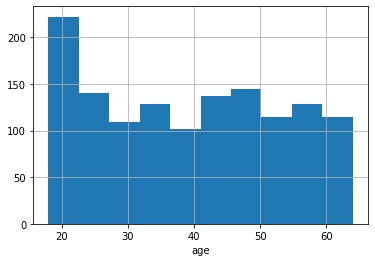

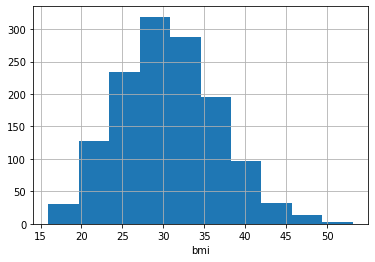

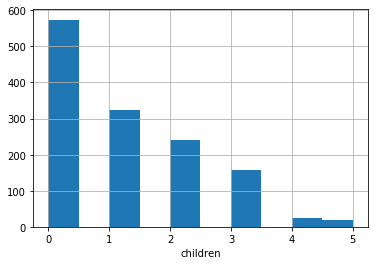

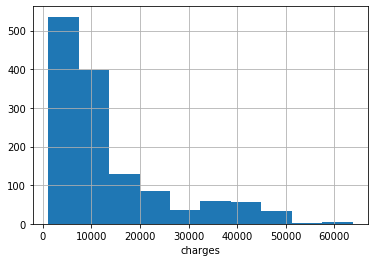

<Figure size 432x288 with 0 Axes>

In [58]:
for col in numCols:
    df[str(col)].hist()
    plt.xlabel(str(col))
#     plt.ylabel("charges")
    plt.show()
    plt.clf()
    

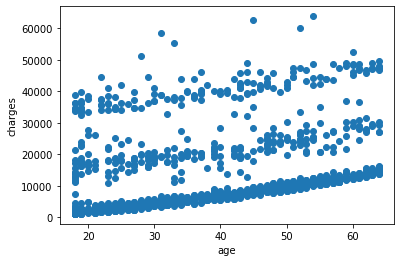

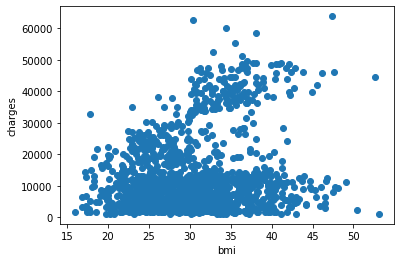

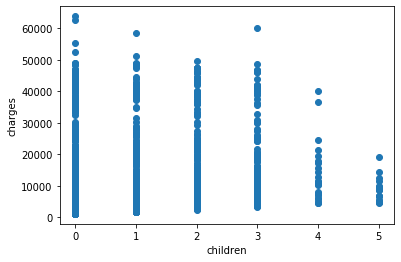

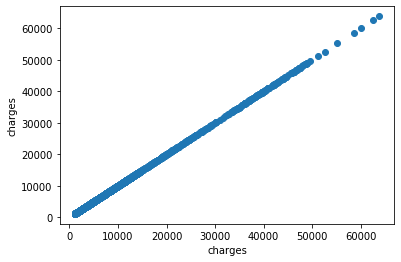

<Figure size 432x288 with 0 Axes>

In [60]:
for col in numCols:
    plt.scatter(x=str(col), y='charges', data=df)
    plt.xlabel(str(col))
    plt.ylabel("charges")
    plt.show()
    plt.clf()


In [61]:
# Normalize age , bmi and charges
def normalize(v):
    return (v - v.mean()) / (v.max() - v.min() + 1)

df[['age' , 'bmi' ]] = df[['age' , 'bmi' ]].apply(normalize)

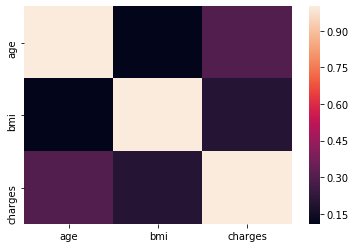

In [76]:
# Check correlation plot for numeric data
sns.heatmap(df[['age' , 'bmi', 'charges' ]].corr())

In [64]:
# Look at the text columns
allCols = list(df.columns)
string = ['object']
strCols = list(rawData.select_dtypes(include=string).columns)

strCols

['sex', 'smoker', 'region']

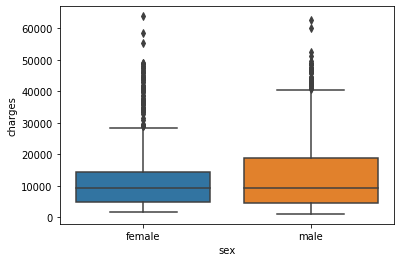

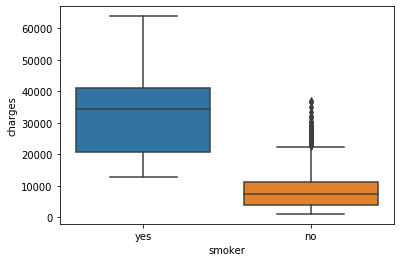

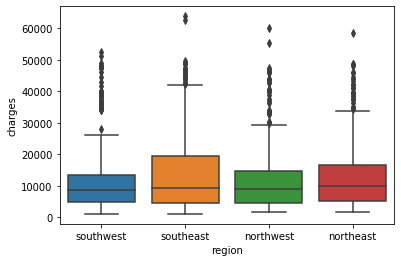

<Figure size 432x288 with 0 Axes>

In [65]:
# Create boxplots for every level of the strCols
for i in range(len(strCols)):
    sns.boxplot(y='charges', x=strCols[i], data=df)
    plt.show()
    plt.clf()

In [183]:
# Encode text columns
df = pd.get_dummies(data=df, columns=strCols, drop_first=True)


In [67]:
# Split data
Y = df['charges']
X = df.drop(columns=['charges'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


In [80]:
dt = tree.DecisionTreeRegressor(max_depth=5)

model = dt.fit(X_train, Y_train)
preds = model.predict(X_test)


In [81]:
print (mean_absolute_error(Y_test, preds), np.sqrt(mean_squared_error(Y_test, preds)))
# RMSE_gradient =np.sqrt(MSE_gradient)


2403.2382552410745 4403.8466661425155


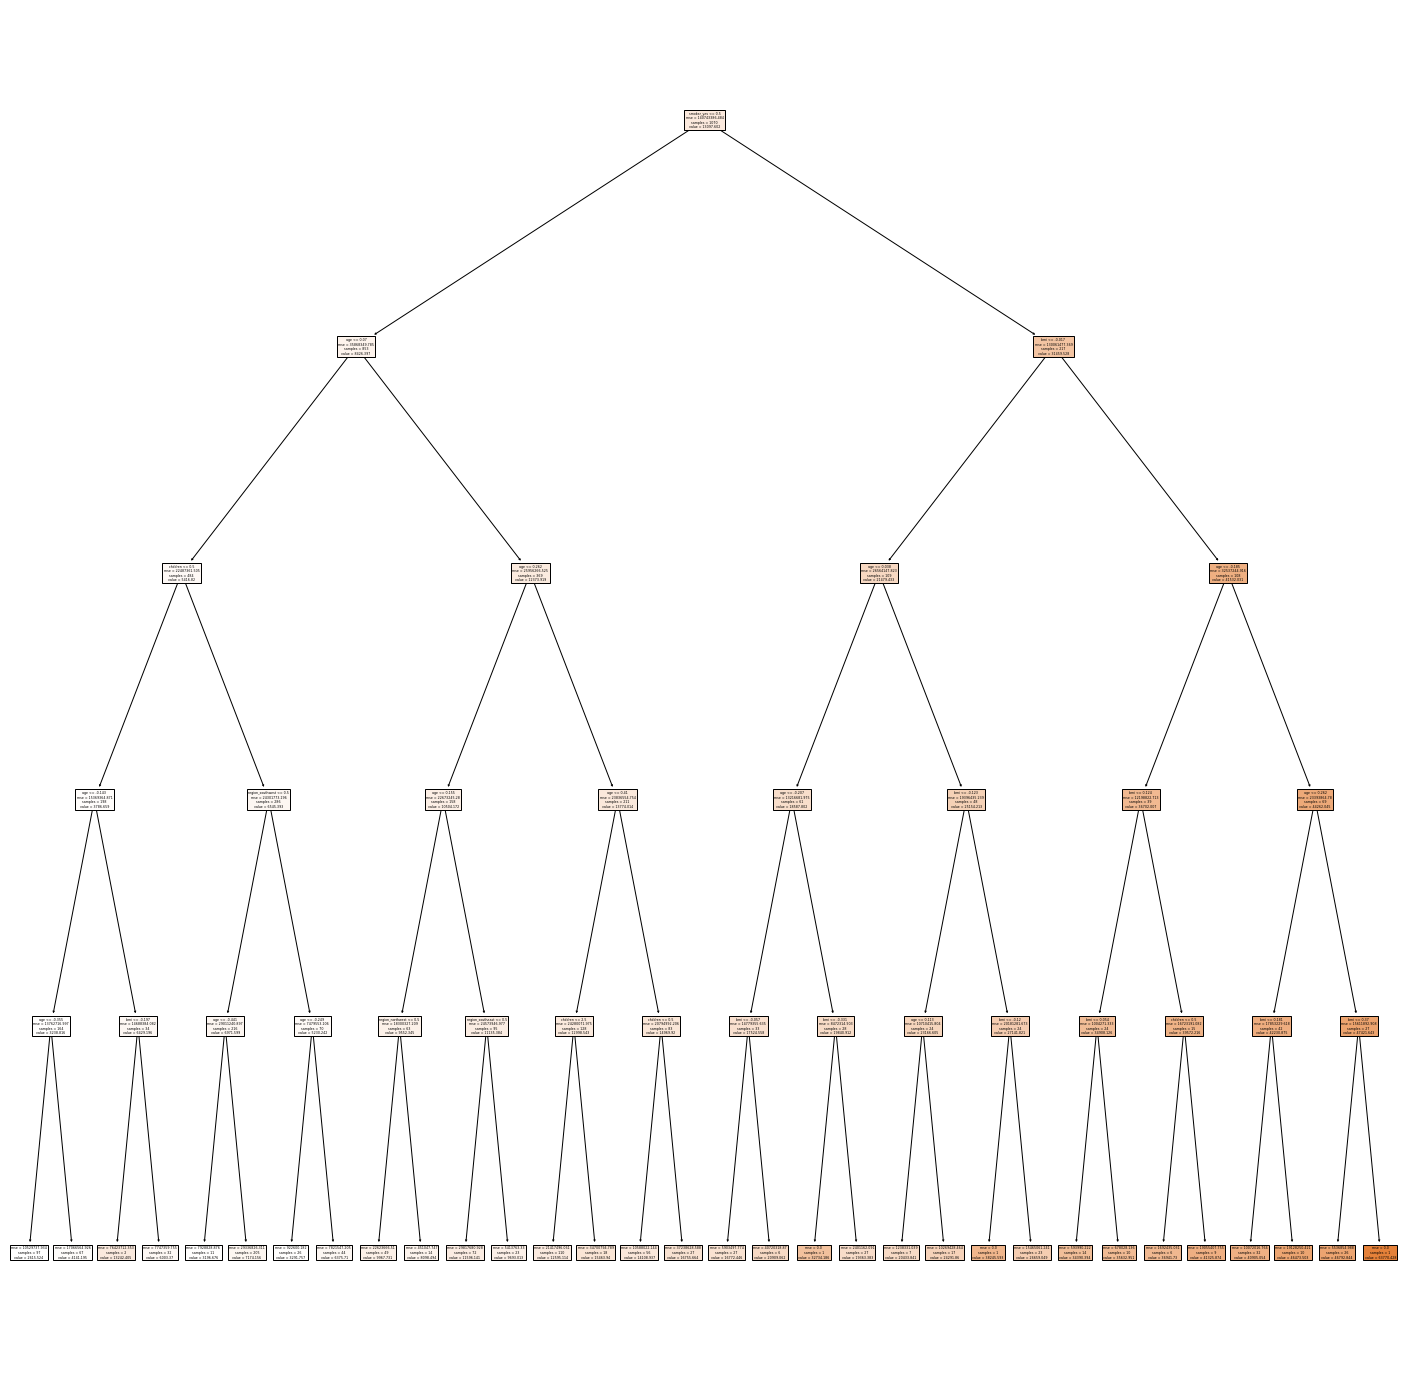

In [82]:
# Visualizing the individual decision tree
fig = plt.figure(figsize=(25,25))
_ = tree.plot_tree(dt, feature_names=X_train.columns,
                   filled=True)

plt.savefig('tree.svg',format='svg', bbox_inches = "tight")


In [97]:
# Cross Validation
searchMatrix = {'max_depth': [3, 5, 7, 10]}
scoreMatrix = {'mse': make_scorer(mean_squared_error)}

dt = tree.DecisionTreeRegressor(random_state=1)
obj = RandomizedSearchCV(estimator=dt, param_distributions=searchMatrix, scoring=scoreMatrix, refit=False,
                        cv=3, return_train_score=True, verbose=2)

obj.fit(X_train, Y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END ........................................max_depth=7; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................m

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=1),
                   param_distributions={'max_depth': [3, 5, 7, 10]},
                   refit=False, return_train_score=True,
                   scoring={'mse': make_scorer(mean_squared_error)}, verbose=2)

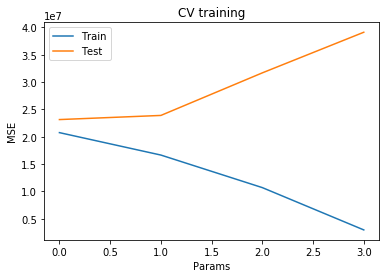

In [108]:
trainErr = obj.cv_results_['mean_train_mse']
valErr = obj.cv_results_['mean_test_mse']
params = obj.cv_results_['params']

fig, ax = plt.subplots()
ax.plot(trainErr, label='Train')
ax.plot(valErr, label='Test')
ax.set(title='CV training', xlabel='Params', 
       ylabel='MSE')
plt.legend()

# Here, we can see the overfitting problem. Error on the trainingset decreases, but on the validation set increases. 

In [110]:
dt = tree.DecisionTreeRegressor(max_depth=3)
dt.fit(X_train, Y_train)
preds = dt.predict(X_test)
print (mean_absolute_error(Y_test, preds), np.sqrt(mean_squared_error(Y_test, preds)))


2791.0444891064462 4633.188752487926


In [115]:
# Train a Random Forest
rf = ensemble.RandomForestRegressor(random_state=1)
model = rf.fit(X_train, Y_train)
preds = model.predict(X_test)
print (mean_absolute_error(Y_test, preds), np.sqrt(mean_squared_error(Y_test, preds)))


2585.146095659739 4786.79412977233


In [121]:
rf = ensemble.RandomForestRegressor(random_state=1)
paramGrid = {'n_estimators': [25, 50, 100, 200], 'max_depth': [3, 5, 7, 10],
            'min_samples_leaf': [1, 3, 5]}
scoreGrid = {'mse': make_scorer(mean_squared_error)}

cvObj = RandomizedSearchCV(estimator=rf, cv=3, scoring=scoreGrid,
                          param_distributions=paramGrid, refit=False, return_train_score=True, verbose=2)
cvObj.fit(X_train, Y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..max_depth=7, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=7, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END ..max_depth=7, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=5, min_samples_leaf=1, n_estimators=25; total time=   0.1s
[CV] END ...max_depth=5, min_samples_leaf=1, n_estimators=25; total time=   0.0s
[CV] END ...max_depth=5, min_samples_leaf=1, n_estimators=25; total time=   0.0s
[CV] END ..max_depth=3, min_samples_leaf=5, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=5, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=3, min_samples_leaf=5, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=10, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=5, n_estimators=50; total time=   0.1s
[CV] END ..max_depth=10, min_samples_leaf=5, n_e

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
                   param_distributions={'max_depth': [3, 5, 7, 10],
                                        'min_samples_leaf': [1, 3, 5],
                                        'n_estimators': [25, 50, 100, 200]},
                   refit=False, return_train_score=True,
                   scoring={'mse': make_scorer(mean_squared_error)}, verbose=2)

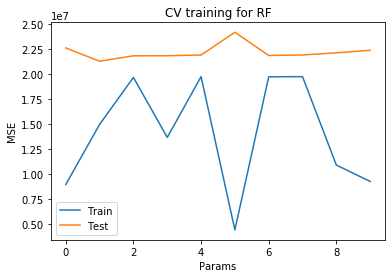

In [122]:
trainErr = cvObj.cv_results_['mean_train_mse']
valErr = cvObj.cv_results_['mean_test_mse']
params = cvObj.cv_results_['params']

fig, ax = plt.subplots()
ax.plot(trainErr, label='Train')
ax.plot(valErr, label='Test')
ax.set(title='CV training for RF', xlabel='Params', 
       ylabel='MSE')
plt.legend()



In [124]:
params

[{'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 7},
 {'n_estimators': 25, 'min_samples_leaf': 1, 'max_depth': 5},
 {'n_estimators': 200, 'min_samples_leaf': 5, 'max_depth': 3},
 {'n_estimators': 50, 'min_samples_leaf': 5, 'max_depth': 10},
 {'n_estimators': 25, 'min_samples_leaf': 3, 'max_depth': 3},
 {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 10},
 {'n_estimators': 50, 'min_samples_leaf': 1, 'max_depth': 3},
 {'n_estimators': 25, 'min_samples_leaf': 5, 'max_depth': 3},
 {'n_estimators': 100, 'min_samples_leaf': 3, 'max_depth': 10},
 {'n_estimators': 25, 'min_samples_leaf': 1, 'max_depth': 7}]

In [127]:
rf = ensemble.RandomForestRegressor(random_state=1)
paramGrid = {'n_estimators': [25, 50, 100, 200, 500],  'max_depth': [3, 5, 7],
            'min_samples_leaf': [1, 3, 5, 10], 'max_features':['auto', 'sqrt']}
scoreGrid = {'mse': make_scorer(mean_squared_error)}

cvObj = RandomizedSearchCV(estimator=rf, cv=3, scoring=scoreGrid,
                          param_distributions=paramGrid, refit=False, return_train_score=True, verbose=2)
cvObj.fit(X_train, Y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=25; total time=   0.1s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=25; total time=   0.0s
[CV] END max_depth=7, max_features=auto, min_samples_leaf=5, n_estimators=25; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=200; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=200; total time=   0.3s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=3, n_estimators=200; total time=   0.3s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.1s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, n_

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
                   param_distributions={'max_depth': [3, 5, 7],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 5, 10],
                                        'n_estimators': [25, 50, 100, 200,
                                                         500]},
                   refit=False, return_train_score=True,
                   scoring={'mse': make_scorer(mean_squared_error)}, verbose=2)

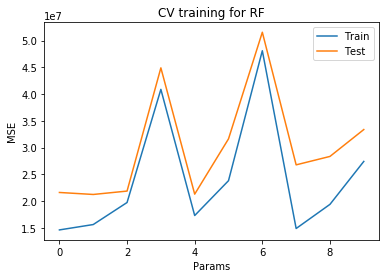

In [128]:
trainErr = cvObj.cv_results_['mean_train_mse']
valErr = cvObj.cv_results_['mean_test_mse']
params = cvObj.cv_results_['params']

fig, ax = plt.subplots()
ax.plot(trainErr, label='Train')
ax.plot(valErr, label='Test')
ax.set(title='CV training for RF', xlabel='Params', 
       ylabel='MSE')
plt.legend()

# Here, we see that the overfitting problem has greatly reduced. 

In [130]:
# From the above plot, we see that the 4th set of hyperparameters did firly well. 
params[4]

{'n_estimators': 100,
 'min_samples_leaf': 10,
 'max_features': 'auto',
 'max_depth': 5}

In [131]:
rf = ensemble.RandomForestRegressor(random_state=1, n_estimators=100,
                                   min_samples_leaf=10, max_features='auto', max_depth=5)

rf.fit(X_train, Y_train)
preds = rf.predict(X_test)
print (mean_absolute_error(Y_test, preds), np.sqrt(mean_squared_error(Y_test, preds)))


2365.6316741954815 4360.209130925052


[1.20470722e-01 1.76198717e-01 8.63708490e-03 7.00008964e-04
 6.92303833e-01 6.04821078e-04 5.07056932e-04 5.77756705e-04]


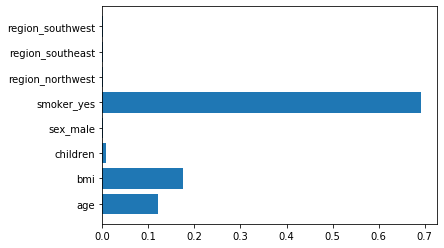

In [138]:
rf.feature_importances_
plt.barh(y=X_train.columns, width=rf.feature_importances_)
print (rf.feature_importances_)

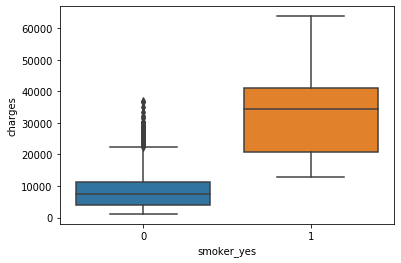

In [141]:
# df['smoker_yes']
sns.boxplot(x='smoker_yes', y='charges', data=df)


In [143]:
# Interpret the model: Explain what the meaning of bias here is. 

prediction, bias, contributions = ti.predict(rf, X_test) # here, bias is the trainset mean


Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

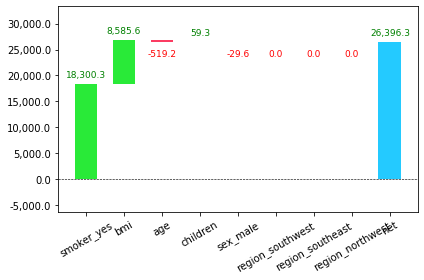

In [173]:
# Smoker
a = list(X_test.columns)
b = contributions[0]
waterfall_chart.plot(a, b, sorted_value=True)


<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

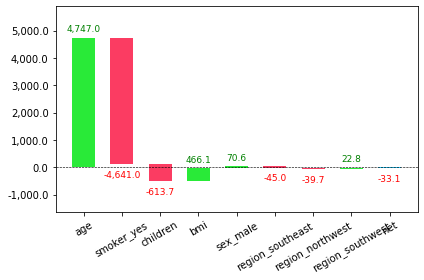

In [177]:
# Non-smoker
a = list(X_test.columns)
b = contributions[1]
waterfall_chart.plot(a, b, sorted_value=True)
